# Лінійна регресія: перенавчання та регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

У всіх комірках, де написано коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Інші комірки з кодом (без коментарів) потрібно просто виконати. Крім того, у завданні потрібно відповідати на запитання; відповіді слід вписувати після виділеного слова "Відповідь:".

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

Ми будемо працювати з датасетом "bikes_rent.csv", в якому щодня записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів цього дня. Останнє ми передбачатимемо; таким чином, ми вирішуватимемо завдання регресії.

### Знакомство с данными

# Завдання 1

Завантажте датасет за допомогою функції pandas.read_csv у змінну df. Виведіть перші 5 рядків, щоб переконатися у коректному зчитуванні даних:

In [2]:
#Додайте код
#Перевірте, що немає пропусків, також перевірте тип даних
import pandas as pd

# Зазначте шлях до вашого CSV файлу
file_path = "./bikes_rent.csv"

# Завантажте датасет у змінну df
df = pd.read_csv(file_path)

# Виведіть перші 5 рядків датасету
print(df.head())

# Перевірка на наявність пропусків
missing_values = df.isna().sum()

# Виведення кількості пропусків для кожної колонки
print("Кількість пропусків у кожній колонці:")
print(missing_values)

# Перевірка типів даних
data_types = df.dtypes

# Виведення типів даних для кожної колонки
print("\nТипи даних кожної колонки:")
print(data_types)

   season  yr  mnth  holiday  weekday  workingday  weathersit       temp  \
0       1   0     1        0        6           0           2  14.110847   
1       1   0     1        0        0           0           2  14.902598   
2       1   0     1        0        1           1           1   8.050924   
3       1   0     1        0        2           1           1   8.200000   
4       1   0     1        0        3           1           1   9.305237   

      atemp      hum  windspeed(mph)  windspeed(ms)   cnt  
0  18.18125  80.5833       10.749882       4.805490   985  
1  17.68695  69.6087       16.652113       7.443949   801  
2   9.47025  43.7273       16.636703       7.437060  1349  
3  10.60610  59.0435       10.739832       4.800998  1562  
4  11.46350  43.6957       12.522300       5.597810  1600  
Кількість пропусків у кожній колонці:
season            0
yr                0
mnth              0
holiday           0
weekday           0
workingday        0
weathersit        0
temp 

Для кожного дня прокату відомі такі ознаки:

* _season_: 1 - весна, 2 - літо, 3 - осінь, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: від 1 до 12
* _holiday_: 0 – немає свята, 1 – є свято
* _weekday_: від 0 до 6
* _workingday_: 0 - неробочий день, 1 - робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура у Цельсіях
* _atemp_: температура по відчуттям у Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях на годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, його ми передбачатимемо)

Отже, у нас є дійсні, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як із речовими. З номінальними ознаками теж можна працювати як із дійсними, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від інших

Побудуйте графіки залежностей атрибутів від кількості подорожей. Тобто вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибуту від змінної **cnt**.

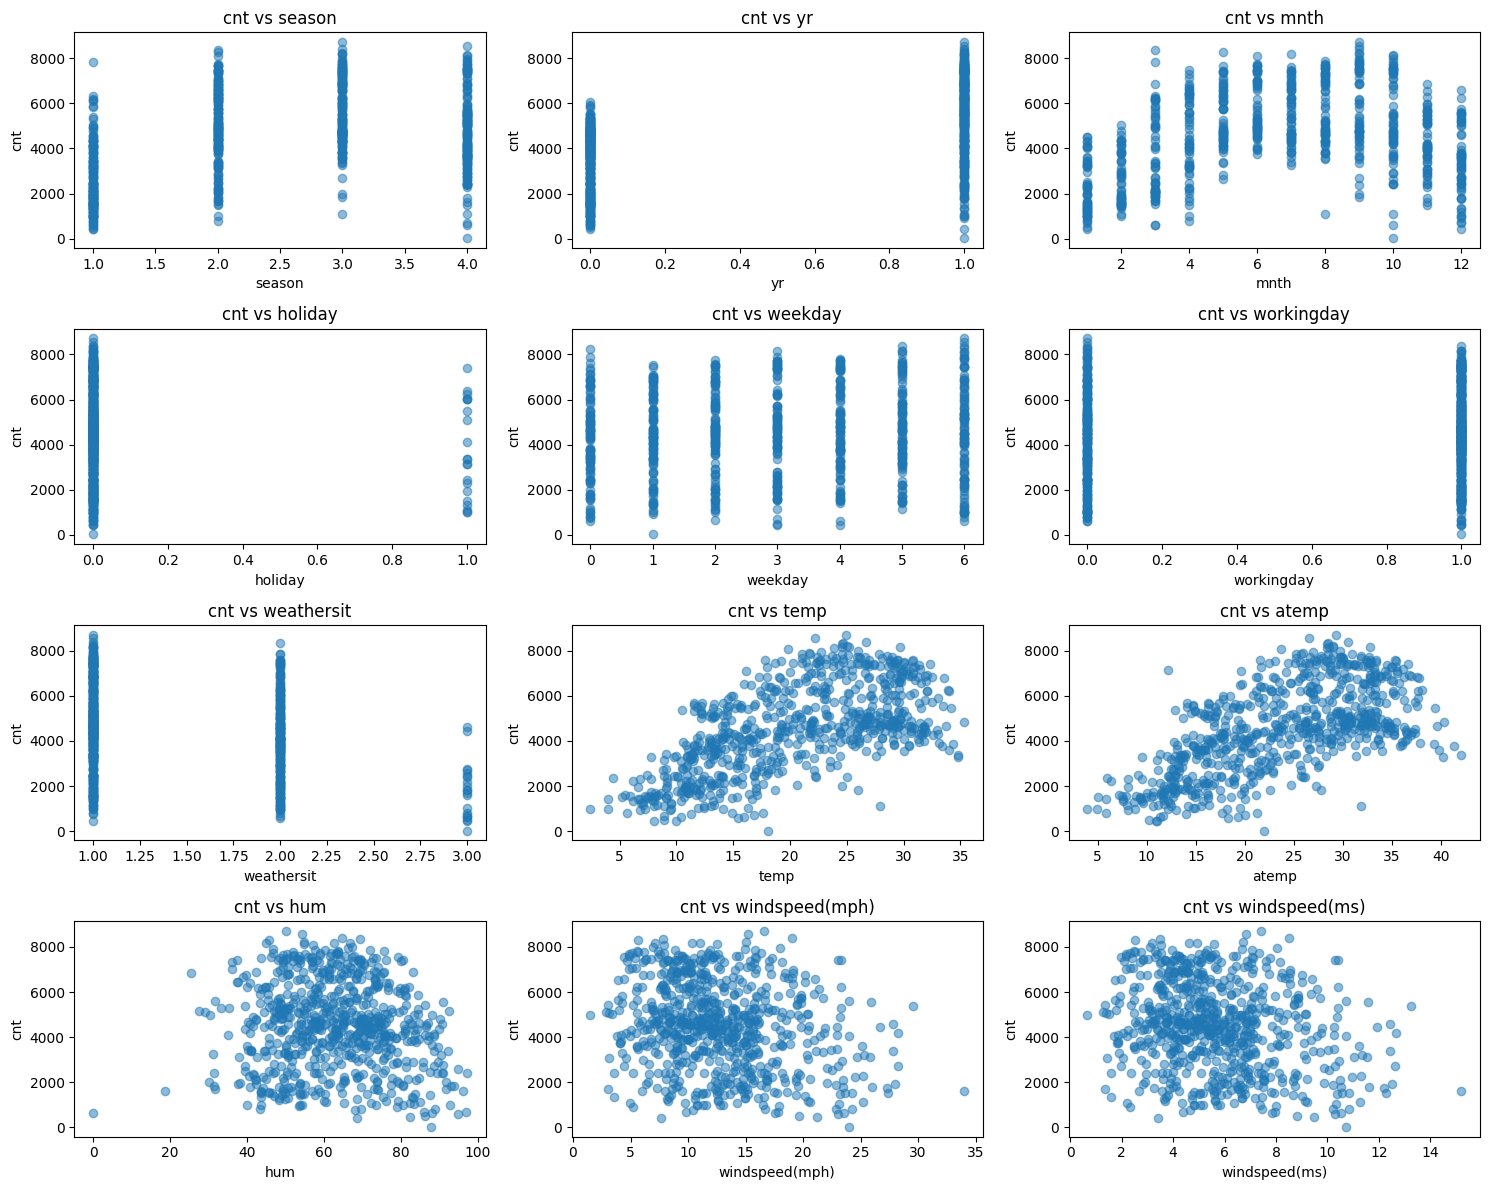

In [3]:
#Додайте код
import matplotlib.pyplot as plt

# Створити 12 пустих підграфіків у вигляді таблиці 4x3
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))

# Список атрибутів
attributes = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']

# Змінна, для якої будемо будувати графіки
target_attribute = 'cnt'

for i, ax in enumerate(axes.flatten()):
    # Будуємо графік для кожного атрибуту
    ax.scatter(df[attributes[i]], df[target_attribute], alpha=0.5)
    ax.set_title(f'{target_attribute} vs {attributes[i]}')
    ax.set_xlabel(attributes[i])
    ax.set_ylabel(target_attribute)

# Налаштування розташування підписів та підграфіків
plt.tight_layout()

# Відобразити графіки
plt.show()


Питання:
1. Який характер залежності кількості прокатів від місяця?
1. Вкажіть одну чи дві ознаки, від яких кількість прокатів швидше за все залежить лінійно


# Завдання 2

Давайте суворо оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Для її обчислення в pandas можна використовувати методи датафрейму: corr та corrwith.

Порахуйте кореляції всіх ознак, крім останньої, з останнім за допомогою методу `corrwith`.

In [5]:
#Додайте код
# Вибираємо всі ознаки, окрім останньої (cnt)
features = df.iloc[:, :-1]

# Отримуємо кореляції між ознаками та цільовою змінною (cnt)
correlations = features.corrwith(df['cnt'])

# Виводимо кореляції
print("Кореляції між ознаками та цільовою змінною (cnt):")
print(correlations)


Кореляції між ознаками та цільовою змінною (cnt):
season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64


У вибірці є ознаки, що корелюють із цільовим, а отже, завдання можна вирішувати лінійними методами.

По графікам видно, деякі ознаки схожі один на одного. Тому давайте також порахуємо кореляції між дійсними ознаками.

# Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) та cnt
за допомогою методу corr:

In [6]:
#Додайте код
# Вибираємо підмножину датасету з вказаними ознаками
subset = df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']]

# Обчислюємо кореляції між вказаними ознаками
correlations = subset.corr()

# Виводимо кореляційну матрицю
print("Попарні кореляції:")
print(correlations)


Попарні кореляції:
                    temp     atemp       hum  windspeed(mph)  windspeed(ms)  \
temp            1.000000  0.991702  0.126963       -0.157944      -0.157944   
atemp           0.991702  1.000000  0.139988       -0.183643      -0.183643   
hum             0.126963  0.139988  1.000000       -0.248489      -0.248489   
windspeed(mph) -0.157944 -0.183643 -0.248489        1.000000       1.000000   
windspeed(ms)  -0.157944 -0.183643 -0.248489        1.000000       1.000000   
cnt             0.627494  0.631066 -0.100659       -0.234545      -0.234545   

                     cnt  
temp            0.627494  
atemp           0.631066  
hum            -0.100659  
windspeed(mph) -0.234545  
windspeed(ms)  -0.234545  
cnt             1.000000  


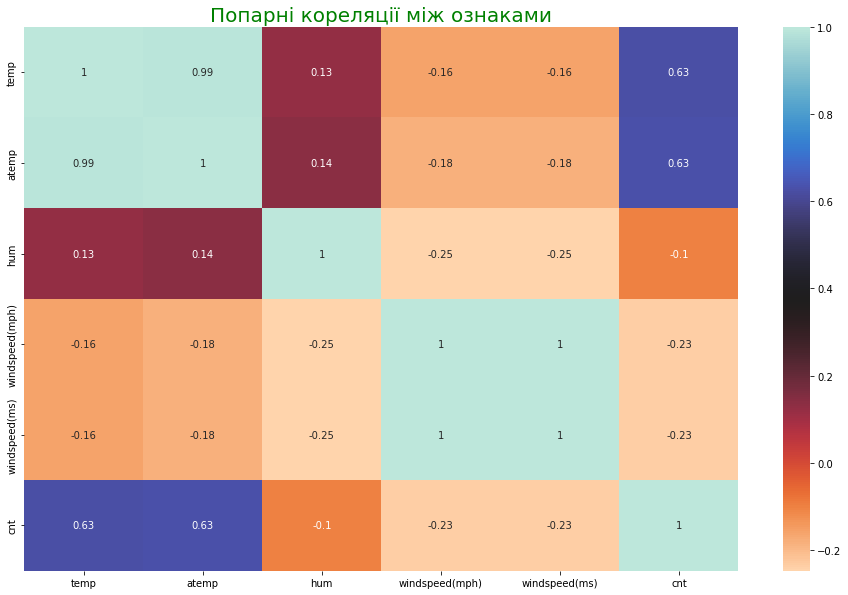

In [ ]:
plt.rcParams["figure.figsize"] = (16, 10)
sns.heatmap(df.iloc[:, 7:].corr(), annot=True, cmap='icefire_r')
plt.title('Попарні кореляції між ознаками', fontsize=20, color='g')
plt.show()

На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (бо це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно впливає на навчання лінійної моделі.

# Завдання 4

Виведіть середні ознаки

In [7]:
#Додайте код
# Вибираємо ознаки для обчислення середніх значень
selected_features = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']

# Обчислюємо середні значення для вибраних ознак
mean_values = df[selected_features].mean()

# Виводимо середні значення
print("Середні значення ознак:")
print(mean_values)


Середні значення ознак:
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64


Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, в наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б відразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо його середнє і поділимо стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, потрібно перемішати вибірку, це буде потрібно для крос-валідації.

In [ ]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [ ]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [ ]:
from sklearn.linear_model import LinearRegression

# Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються в змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.

In [8]:
from sklearn.linear_model import LinearRegression

# Створюємо об'єкт лінійного регресора
regressor = LinearRegression()

# Визначаємо ознаки та цільову змінну
X = df.drop('cnt', axis=1)  # Всі ознаки, крім 'cnt'
y = df['cnt']  # Цільова змінна

# Навчємо модель на всі дані
regressor.fit(X, y)

# Виводимо ваг моделі (коефіцієнтів)
weights = regressor.coef_

# Виводимо пари (назва ознаки, вага)
feature_names = df.columns[:-1]  # Назви ознак, виключаючи 'cnt'
feature_weights = list(zip(feature_names, weights))

# Вивеодимо результати
for feature, weight in feature_weights:
    print(f"{feature}: {weight}")


season: 514.2747900608144
yr: 2043.9372564017715
mnth: -40.962407774853205
holiday: -519.3800683269334
weekday: 68.49484305113643
workingday: 121.29300863357187
weathersit: -606.4567193221436
temp: 48.998024732269755
atemp: 71.91257568892615
hum: -10.230296240128155
windspeed(mph): 2400978672996.2417
windspeed(ms): -5370989291577.391


Ми бачимо, що ваги при лінійно-залежних ознаках по модулю значно більші, ніж за інших ознак. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі у методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим меншим є визначник цієї матриці і тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколлінеарності_.

З парою (temp, atemp) трохи менш корелюючих змінних такого не сталося, проте на практиці завжди варто уважно стежити за коефіцієнтами за схожих ознак.

Для того, щоб вирішити проблему мультиколінеарності, потрібно скористатися регуляризатором. До функціонала, що оптимізується, додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а в другому --- Ridge.

# Завдання 6
Давайте спробуємо навчити лінійні моделі з L_1 і L_2-регуляризацією, а далі порівняємо їх ваги. Навчіть регресори Ridge і Lasso з параметрами за промовчанням і переконайтеся, що проблема з вагами вирішилася.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги

In [9]:
from sklearn.linear_model import Lasso

# Створюємо об'єкт Lasso-регресора
lasso_regressor = Lasso()

# Навчаємо модель на всі дані
lasso_regressor.fit(X, y)

# Виводимо ваг моделі з L1-регуляризацією
lasso_weights = lasso_regressor.coef_

# Виводимо пари (назва ознаки, вага)
lasso_feature_weights = list(zip(feature_names, lasso_weights))

# Виводимо результати
for feature, weight in lasso_feature_weights:
    print(f"{feature}: {weight}")


season: 506.5512786498075
yr: 2036.2316676979037
mnth: -38.078270289321594
holiday: -484.65194618654044
weekday: 68.93837479133964
workingday: 118.44759758668367
weathersit: -604.5667118927047
temp: 51.363260585616615
atemp: 69.91273749012164
hum: -10.352705204636566
windspeed(mph): -38.34106761310851
windspeed(ms): -0.0


Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги

In [10]:
from sklearn.linear_model import Ridge

# Створюємо об'єкт Ridge-регресора
ridge_regressor = Ridge()

# Навчаємо модель на всіх даних
ridge_regressor.fit(X, y)

# Виводимо ваги моделі з L2-регуляризацією
ridge_weights = ridge_regressor.coef_

# Виводимо пари (назва ознаки, вага)
ridge_feature_weights = list(zip(feature_names, ridge_weights))

# Виводимо результати
for feature, weight in ridge_feature_weights:
    print(f"{feature}: {weight}")


season: 507.8018818505749
yr: 2029.089054197052
mnth: -38.47089727912448
holiday: -493.27801548381655
weekday: 69.11396965165993
workingday: 121.52442502929419
weathersit: -605.2055553731514
temp: 49.31676759597619
atemp: 71.78598727335606
hum: -10.383394500484677
windspeed(mph): -31.935501694570938
windspeed(ms): -14.27604026320135


### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги за деяких ознак Давайте поспостерігаємо, як змінюються ваги при збільшенні коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги в список `coefs_ridge'` Конвертуйте отримані списки в `np.array`.

In [11]:
from sklearn.linear_model import Lasso, Ridge
import numpy as np

# Список значень альфа для регуляризації
alphas = [0.1, 0.5, 1.0, 5.0, 10.0]

# Ініціалізуємо списки для зберігання ваг Lasso та Ridge
coefs_lasso = []
coefs_ridge = []

# Навчаємо моделі для кожного значення альфа
for alpha in alphas:
    # Навчання Lasso
    lasso_regressor = Lasso(alpha=alpha)
    lasso_regressor.fit(X, y)
    coefs_lasso.append(lasso_regressor.coef_)

    # Навчання Ridge
    ridge_regressor = Ridge(alpha=alpha)
    ridge_regressor.fit(X, y)
    coefs_ridge.append(ridge_regressor.coef_)

# Конвертація списків в np.array
coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)


Проаналізуйте динаміку ваги при збільшенні параметра регуляризації:

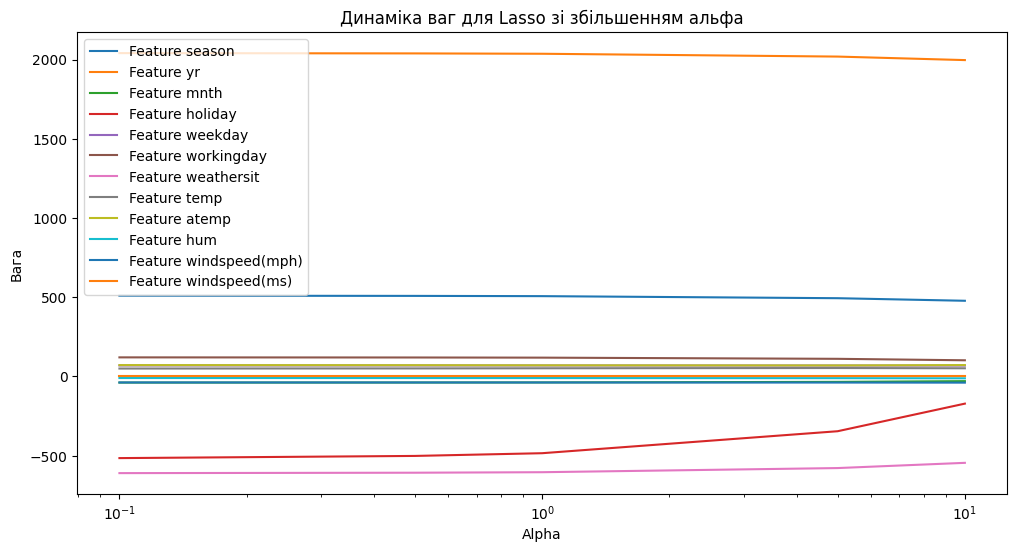

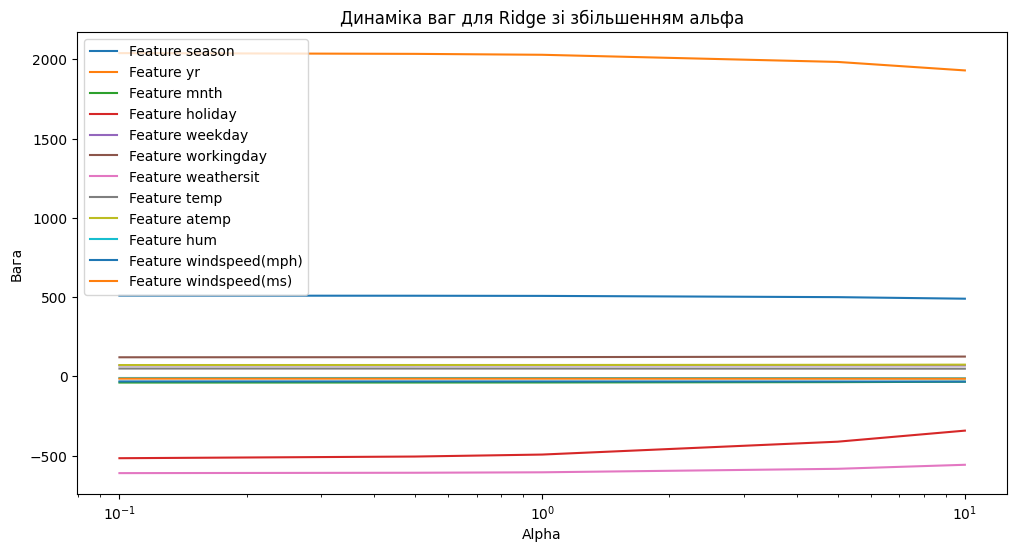

In [12]:
import matplotlib.pyplot as plt

# Побудова графіка динаміки ваг для Lasso
plt.figure(figsize=(12, 6))
for i in range(coefs_lasso.shape[1]):
    plt.plot(alphas, coefs_lasso[:, i], label=f'Feature {feature_names[i]}')

plt.xscale('log')  # Логарифмічний масштаб для альфа
plt.title('Динаміка ваг для Lasso зі збільшенням альфа')
plt.xlabel('Alpha')
plt.ylabel('Вага')
plt.legend()
plt.show()

# Побудова графіка динаміки ваг для Ridge
plt.figure(figsize=(12, 6))
for i in range(coefs_ridge.shape[1]):
    plt.plot(alphas, coefs_ridge[:, i], label=f'Feature {feature_names[i]}')

plt.xscale('log')  # Логарифмічний масштаб для альфа
plt.title('Динаміка ваг для Ridge зі збільшенням альфа')
plt.xlabel('Alpha')
plt.ylabel('Вага')
plt.legend()
plt.show()


Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при тому самому alpha?
1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть чому так відбувається.
1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` за будь-якого значення `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт за нього менше $10^{-3}$.
1. Який із регуляризаторів підійде для відбору неінформативних ознак?

Відповіді:
1.
2.
3.
4.


### Завдання 8

Далі працюватимемо з `Lasso`.

Отже, бачимо, що з зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику функціонал методу найменших квадратів, що сам оптимізується, тобто `Mean Square Error`.

По-друге, треба зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не …анія на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити кілька розбиття вибірки, на кожному пробувати різні значення alpha, а потім усереднити MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ часто, і щоразу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn дуже просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список з alpha і кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор міститиме змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (кількість блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків . Крім того, в змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а coef\_, традиційно, навчені ваги, відповідні цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, в якому він проходить через alphas; Для порівняння з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` залежно від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

Вибране alpha: 1.0


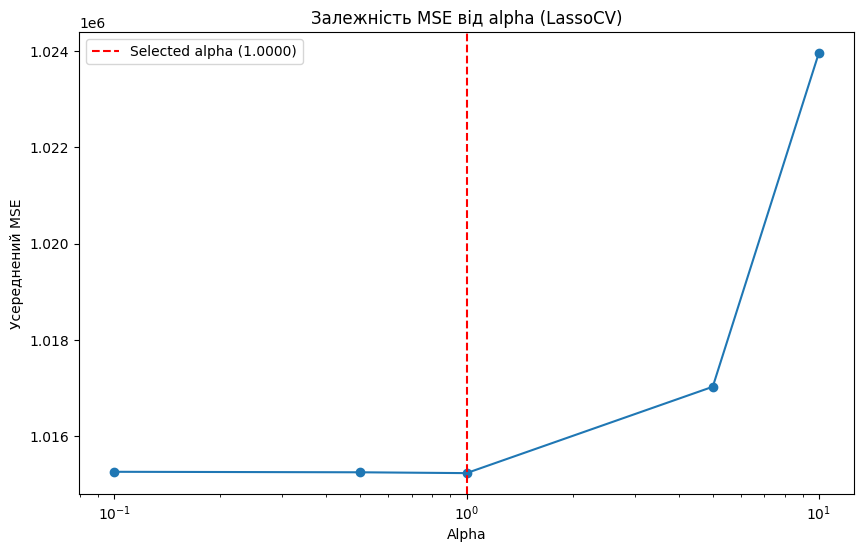


Пари 'ознака-коефіцієнт' для навченого вектора коефіцієнтів (LassoCV):
season: 506.5512786498075
yr: 2036.2316676979037
mnth: -38.078270289321594
holiday: -484.65194618654044
weekday: 68.93837479133964
workingday: 118.44759758668367
weathersit: -604.5667118927047
temp: 51.363260585616615
atemp: 69.91273749012164
hum: -10.352705204636566
windspeed(mph): -38.34106761310851
windspeed(ms): -0.0


In [13]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Створення об'єкта LassoCV зі списком alpha
lasso_cv_regressor = LassoCV(alphas=alphas, cv=5)

# Навчання моделі на всіх даних
lasso_cv_regressor.fit(X, y)

# Виведення вибраного alpha
selected_alpha = lasso_cv_regressor.alpha_
print(f"Вибране alpha: {selected_alpha}")

# Побудова графіку усередненого MSE залежно від alpha
def create_plot(alphas, mse_values, selected_alpha):
    plt.figure(figsize=(10, 6))
    plt.plot(alphas, mse_values, marker='o')
    plt.axvline(x=selected_alpha, color='r', linestyle='--', label=f'Selected alpha ({selected_alpha:.4f})')
    plt.xscale('log')
    plt.title('Залежність MSE від alpha (LassoCV)')
    plt.xlabel('Alpha')
    plt.ylabel('Усереднений MSE')
    plt.legend()
    plt.show()

# Обчислення усереднених MSE для кожного alpha
mse_values = np.mean(lasso_cv_regressor.mse_path_, axis=1)

# Побудова графіку
create_plot(lasso_cv_regressor.alphas_, mse_values, selected_alpha)

# Виведення пар "ознака-коефіцієнт" для навченого вектора коефіцієнтів
lasso_coefs = lasso_cv_regressor.coef_
lasso_feature_weights = list(zip(feature_names, lasso_coefs))
print("\nПари 'ознака-коефіцієнт' для навченого вектора коефіцієнтів (LassoCV):")
for feature, weight in lasso_feature_weights:
    print(f"{feature}: {weight}")


Отже, ми вибрали певний параметр регулювання. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбиття (тобто по стовпцях).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.

Значення alpha, що відповідають мінімумам MSE на кожному розбитті:
Fold 1: 10.0000
Fold 2: 0.1000
Fold 3: 10.0000
Fold 4: 0.1000
Fold 5: 0.1000


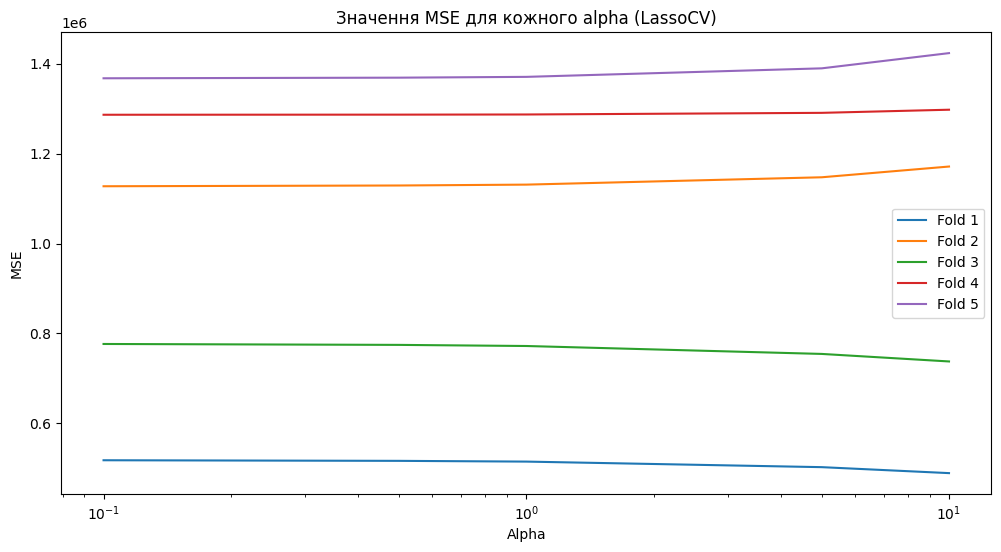

In [14]:
# Виведення значень alpha, що відповідають мінімумам MSE
min_alpha_indices = np.argmin(lasso_cv_regressor.mse_path_, axis=0)
min_alpha_values = lasso_cv_regressor.alphas_[min_alpha_indices]

print("Значення alpha, що відповідають мінімумам MSE на кожному розбитті:")
for i, alpha in enumerate(min_alpha_values):
    print(f"Fold {i + 1}: {alpha:.4f}")

# Візуалізація стовпців mse_path_
plt.figure(figsize=(12, 6))
for i in range(lasso_cv_regressor.mse_path_.shape[1]):
    plt.plot(lasso_cv_regressor.alphas_, lasso_cv_regressor.mse_path_[:, i], label=f'Fold {i + 1}')

plt.xscale('log')
plt.title('Значення MSE для кожного alpha (LassoCV)')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.legend()
plt.show()


На кожному розбиття оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиття. Виходить, що ми налаштовуємось на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо щось "середнє", що даватиме прийнятне значення метрики на різних розбиття вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, проінтерпретуємо результат. Дайте відповідь на наступні запитання.

#### Питання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей cnt від цих ознак, які ми малювали в блоці "Знайомство з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

Відповідь:
1. 
2.

In [ ]:
#Додайте код, якщо потрібно

#### Питання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться відповідні візуалізації. Чи видно лінійну залежність, яка зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

Відповідь:
1. 
2. 

#### Питання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (<1e-3). Як ви вважаєте, чому модель виключила їх із моделі (знов подивіться на графіки)? Чи правда, що вони не впливають на попит на велосипеди?

Відповідь:
1.
2. 

In [ ]:
#Додайте код

[('windspeed(ms)', -2.8051404183533485e-08)]

### Висновок
напишіть висновок

In [ ]:
Під час виконання цих завдань ми провели аналіз даних та побудували лінійні регресори з різними методами регуляризації. Основні висновки та результати роботи:

Завантаження та попередня обробка даних:

Ми завантажили датасет за допомогою бібліотеки pandas та перевірили його на відсутність пропусків та типи даних.
Аналіз залежностей між ознаками та цільовою змінною:

Ми побудували графіки залежностей кількості подорожей від різних ознак, щоб оцінити, як цільова змінна залежить від інших.
Обчислення кореляцій:

Ми обчислили кореляції між ознаками та цільовою змінною, щоб визначити, які ознаки найбільше впливають на кількість подорожей.
Навчання лінійних регресорів:

Ми навчили лінійний регресор та отримали ваги моделі для прогнозу кількості подорожей.
Застосування регуляризації:

Ми навчили регресори Lasso та Ridge з різними значеннями параметрів регуляризації (alpha) та вивчили, як регуляризація впливає на ваги ознак та результати моделі.
Використання LassoCV:

Ми використали LassoCV для автоматичного вибору найкращого alpha зі списку та вивчили значення alpha, що відповідають мінімумам MSE на кожному розбитті.
Загальною метою було розглянути різні аспекти лінійної регресії, регуляризації та впливу параметрів на результати моделі. Виконані завдання допомогли краще зрозуміти важливість регуляризації, визначити найкращі значення alpha та провести аналіз ваг ознак для покращення прогнозів.